In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../")

In [4]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [5]:
from pathlib import Path

trajectories = [
    {"model": "Llama3-8b", "dataset": "cc", "lens": "tuned", "prompt": "Instruct", "dir":  Path("../data/trajectories/common_claim/llama_3_8b/tuned/cc/binary/seed_42")},
    {"model": "Llama3-8b", "dataset": "cc", "lens": "tuned", "prompt": "Pretrained", "dir":  Path("../data/trajectories/common_claim/llama_3_8b/tuned/cc/binary_pretrained/seed_42")},
    {"model": "Llama3-8b-Instruct", "dataset": "cc", "lens": "tuned", "prompt": "Instruct", "dir":  Path("../data/trajectories/common_claim/llama_3_8b_instruct/tuned/cc/binary/seed_42")},
    {"model": "Llama3-8b-Instruct", "dataset": "cc", "lens": "tuned", "prompt": "Pretrained", "dir":  Path("../data/trajectories/common_claim/llama_3_8b_instruct/tuned/cc/binary_pretrained/seed_42")},
    # {"model": "Llama3-8b-Instruct", "dataset": "cc", "lens": "tuned", "prompt": "CoT", "dir":  Path("../data/trajectories/common_claim/llama_3_8b_instruct/tuned/cc/binary_cot/seed_42")},
    {"model": "Llama3-8b-Instruct", "dataset": "mmlu", "lens": "tuned", "prompt": "Instruct", "dir":  Path("../data/trajectories/mmlu/llama_3_8b_instruct/tuned/seed_42")},
    # {"model": "Llama3-8b-Instruct", "dataset": "mmlu", "lens": "tuned", "prompt": "Simple", "dir":  Path("../data/trajectories/mmlu/llama_3_8b_instruct/tuned/mmlu/simple/seed_42")},
]

In [6]:
import json

results = []

for data in trajectories:
    answers_file = data["dir"] / "answers.jsonl"
    with answers_file.open("r") as f:
        a = json.load(f)
    
    stats_file = data["dir"] / "stats.jsonl"
    with stats_file.open("r") as f:
        s = json.load(f)

    results.append({
        "model": data["model"],
        "lens": data["lens"],
        "dataset": data["dataset"],
        "prompt": data["prompt"],
        "answers": a,
        "stats": s,
    })

In [7]:
import numpy as np

for res in results:
    print(f"{res['model']}; prompt - {res['prompt']}")
    for uc in np.unique([a["answer"] for a in res["answers"]], return_counts=True):
        print(uc)
    print()


Llama3-8b; prompt - Instruct
['<|end_of_text|>' 'ĠFalse' 'ĠTrue' 'ĠĊ']
[   1    8 4440    1]

Llama3-8b; prompt - Pretrained
[':ĊĊ' 'ĊĊ' 'ĠFalse' 'ĠTrue' 'Ġfalse']
[  48    1 1610 2786    5]

Llama3-8b-Instruct; prompt - Instruct
['False' 'True']
[2197 2253]

Llama3-8b-Instruct; prompt - Pretrained
['**' 'A' 'According' 'Based' 'FALSE' 'False' 'I' 'TRUE' 'This' 'True'
 'What']
[ 115  334  108   43 1621  337   30 1159   27  665   11]

Llama3-8b-Instruct; prompt - Instruct
['A' 'B' 'C' 'D' 'K']
[2939 4744 3204 3154    1]



In [8]:
import pandas as pd
from tabulate import tabulate

def create_latex_table_from_counts(results):
    table_data = []
    for data in results:
        answers = [a["answer"].lower().replace('ġ', '') for a in data["answers"]]
        counts = pd.Series(answers).value_counts()
        total = len(answers)
        
        table_data.append([
            data["model"],
            data["prompt"],
            f"{counts.get('true', 0)} ({counts.get('true', 0)/total:.2%})",
            f"{counts.get('false', 0)} ({counts.get('false', 0)/total:.2%})", 
            f"{total - counts.get('true', 0) - counts.get('false', 0)} ({(total - counts.get('true', 0) - counts.get('false', 0))/total:.2%})"
        ])

    df = pd.DataFrame(table_data, columns=['Model', 'Prompt', 'True', 'False', 'Empty'])
    return df, tabulate(df, headers='keys', tablefmt='latex', showindex=False)

cc_results = [res for res in results if res["dataset"] == "cc"]
df, latex_table = create_latex_table_from_counts(cc_results)
print("LaTeX Table:")
print(latex_table)

df

LaTeX Table:
\begin{tabular}{lllll}
\hline
 Model              & Prompt     & True          & False         & Empty        \\
\hline
 Llama3-8b          & Instruct   & 4440 (99.78\%) & 8 (0.18\%)     & 2 (0.04\%)    \\
 Llama3-8b          & Pretrained & 2786 (62.61\%) & 1615 (36.29\%) & 49 (1.10\%)   \\
 Llama3-8b-Instruct & Instruct   & 2253 (50.63\%) & 2197 (49.37\%) & 0 (0.00\%)    \\
 Llama3-8b-Instruct & Pretrained & 1824 (40.99\%) & 1958 (44.00\%) & 668 (15.01\%) \\
\hline
\end{tabular}


,Model,Prompt,True,False,Empty
0,Llama3-8b,Instruct,4440 (99.78%),8 (0.18%),2 (0.04%)
1,Llama3-8b,Pretrained,2786 (62.61%),1615 (36.29%),49 (1.10%)
2,Llama3-8b-Instruct,Instruct,2253 (50.63%),2197 (49.37%),0 (0.00%)
3,Llama3-8b-Instruct,Pretrained,1824 (40.99%),1958 (44.00%),668 (15.01%)


In [9]:
import pandas as pd
from tabulate import tabulate

def create_latex_table_from_counts(results):
    table_data = []
    for data in results:
        answers = pd.Series([a["answer"] for a in data["answers"]])
        counts = answers.value_counts()
        total = len(answers)
        
        table_data.append([
            data["model"],
            data["prompt"],
            f"{counts.get('A', 0)} ({counts.get('A', 0)/total:.2%})",
            f"{counts.get('B', 0)} ({counts.get('B', 0)/total:.2%})",
            f"{counts.get('C', 0)} ({counts.get('C', 0)/total:.2%})",
            f"{counts.get('D', 0)} ({counts.get('D', 0)/total:.2%})",
            f"{counts[~counts.index.isin(['A','B','C','D'])].sum()} ({counts[~counts.index.isin(['A','B','C','D'])].sum()/total:.2%})"
        ])

    df = pd.DataFrame(table_data, columns=['Model', 'Prompt', 'A', 'B', 'C', 'D', 'Empty'])
    latex_table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)
    return df, latex_table

mmlu_results = [res for res in results if res["dataset"] == "mmlu"]
df, latex_table = create_latex_table_from_counts(mmlu_results)
print("LaTeX Table:")
print(latex_table)

df

LaTeX Table:
\begin{tabular}{lllllll}
\hline
 Model              & Prompt   & A             & B             & C             & D             & Empty     \\
\hline
 Llama3-8b-Instruct & Instruct & 2939 (20.93\%) & 4744 (33.78\%) & 3204 (22.82\%) & 3154 (22.46\%) & 1 (0.01\%) \\
\hline
\end{tabular}


,Model,Prompt,A,B,C,D,Empty
0,Llama3-8b-Instruct,Instruct,2939 (20.93%),4744 (33.78%),3204 (22.82%),3154 (22.46%),1 (0.01%)


In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score


def process_answers(answers, dataset):
    if dataset == "cc":
        return ["True" if "true" in a.lower() else "False" if "false" in a.lower() else "" for a in answers]
    elif dataset == "mmlu":
        return [a if a in ["A", "B", "C", "D"] else "" for a in answers]
    else:
        raise ValueError(f"Invalid dataset: {dataset}")

def create_dataframe(result):
    df = pd.DataFrame(result["stats"])
    stats_columns = list(df.columns)
    
    df["answers"] = process_answers([a["answer"] for a in result["answers"]], result["dataset"])
    df["gold"] = [a["gold"] for a in result["answers"]]
    for col in ["lens", "model", "dataset", "prompt"]:
        df[col] = result[col]
    if "subject" in result["answers"][0]:
        df["subject"] = [a["subject"] for a in result["answers"]]
    df["correct"] = (df["answers"] == df["gold"])
    df["id"] = range(len(df))
    
    df = df.explode(stats_columns)
    df['layer'] = df.groupby('id').cumcount() + 1
    
    return df.reset_index(drop=True)

dfs = [create_dataframe(res) for res in results]
df = pd.concat(dfs)


In [10]:
# Calculate accuracy per model/dataset/prompt combination
accuracy_df = df.groupby(['model', 'dataset', 'prompt'])['correct'].mean().reset_index()
accuracy_df = accuracy_df.rename(columns={'correct': 'accuracy'})
accuracy_df.columns = ["Model", "Dataset", "Prompt", "Accuracy"]
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)
accuracy_df["Accuracy"] = accuracy_df["Accuracy"].apply(lambda x: f"{x:.2%}")
display(accuracy_df)


,Model,Dataset,Prompt,Accuracy
2,Llama3-8b-Instruct,cc,Instruct,75.19%
1,Llama3-8b,cc,Pretrained,70.97%
3,Llama3-8b-Instruct,cc,Pretrained,64.45%
4,Llama3-8b-Instruct,mmlu,Instruct,60.90%
0,Llama3-8b,cc,Instruct,50.11%


In [11]:
cc_token_prob_cols = ["True_token_prob", "False_token_prob"]
mmlu_token_prob_cols = ["A_token_prob", "B_token_prob", "C_token_prob", "D_token_prob"]

stat_cols = ["entropy", "forward_kl", "cross_entropy", "max_prob"]

In [12]:
from scipy.stats import entropy
from tqdm import tqdm

for dataset, token_prob_cols in [("cc", cc_token_prob_cols), ("mmlu", mmlu_token_prob_cols)]:
    print(f"Processing {dataset} dataset")

    probs = df.loc[df["dataset"] == dataset][token_prob_cols].values

    entropies = []
    for i in tqdm(range(probs.shape[0])):
        if np.sum(probs[i]) > 0:
            e = entropy(list(probs[i]))
        else:
            e = 0
        entropies.append(e)
        
    df.loc[df["dataset"] == dataset, "answer_token_entropy"] = entropies

stat_cols = stat_cols + ["answer_token_entropy"]


Processing cc dataset


100%|██████████| 587400/587400 [01:51<00:00, 5270.76it/s]


Processing mmlu dataset


100%|██████████| 463386/463386 [02:19<00:00, 3322.36it/s]


# Answer tokens probabilities

In [13]:
id_vars = ['model', 'dataset', 'prompt', 'lens', 'layer', 'correct', 'answers', 'gold', 'id', 'subject']

cc_melted = df[df['dataset'] == 'cc'].melt(
    id_vars=id_vars,
    value_vars=cc_token_prob_cols,
    var_name='stat_name',
    value_name='stat_value'
)

mmlu_melted = df[df['dataset'] == 'mmlu'].melt(
    id_vars=id_vars, 
    value_vars=mmlu_token_prob_cols,
    var_name='stat_name',
    value_name='stat_value'
)

df_token_probs = {"cc": cc_melted, "mmlu": mmlu_melted}

for dataset in ['cc', 'mmlu']:
    df_token_probs[dataset]['token'] = df_token_probs[dataset]['stat_name'].str.split('_').str[0]
    df_token_probs[dataset]['stat_name'] = 'Token prob.'


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

def plot_token_probs(df, token_cols, height=3):
    g = sns.FacetGrid(df[df["answers"].isin(token_cols)], col="model", row="prompt", height=height, aspect=1.8)
    g.map_dataframe(sns.lineplot, x="layer", y="stat_value", hue="token", style="answers", markers=True, dashes=False, errorbar='sd', legend=True)
    g.set_titles("{col_name} - {row_name}")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Token Probabilities Across Layers", fontsize=16)
    g.set(xlabel="Layer", ylabel="Token probability")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

In [1]:
df_token_probs[dataset].head()

NameError: name 'df_token_probs' is not defined

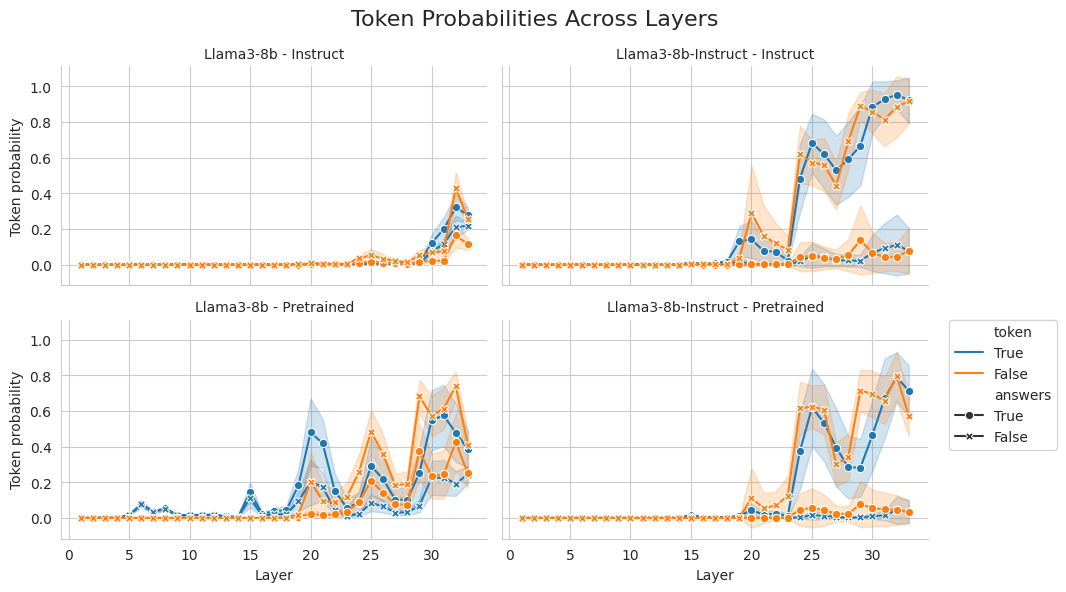

In [15]:
plot_token_probs(df_token_probs["cc"], ["True", "False"], 3)

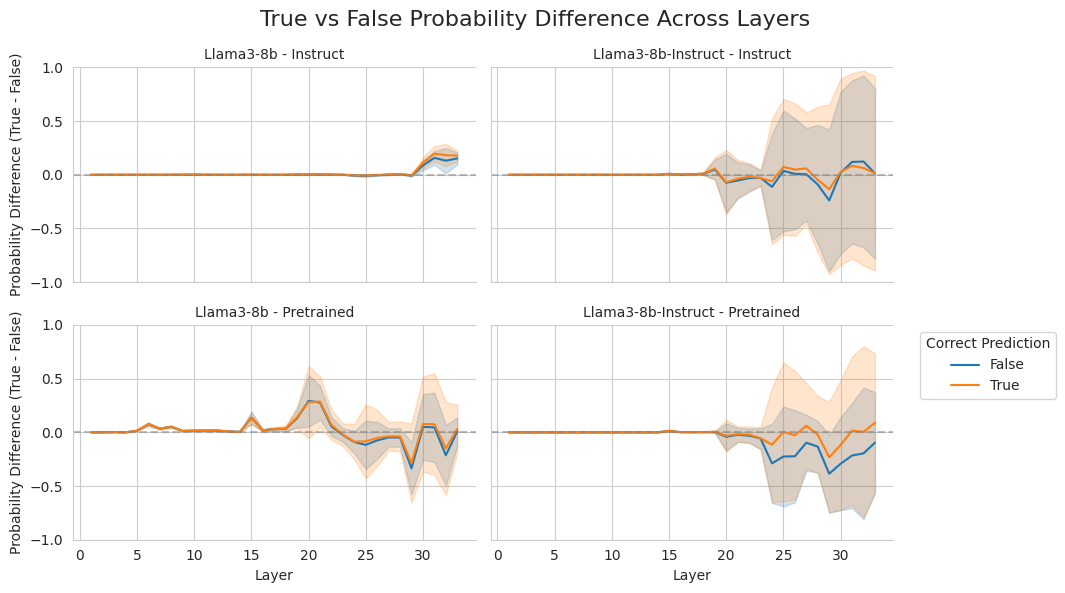

In [30]:
# Calculate probability differences (True - False)
df_cc = df[df['dataset'] == 'cc'].copy()
df_cc['prob_diff'] = df_cc['True_token_prob'] - df_cc['False_token_prob']

# Create the plot
g = sns.FacetGrid(df_cc, col="model", row="prompt", height=3, aspect=1.8)
g.map_dataframe(
    sns.lineplot, 
    x="layer", 
    y="prob_diff", 
    hue="correct",
    errorbar='sd',
    markers=True,
    dashes=False
)

# Customize the plot
g.set_titles("{col_name} - {row_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("True vs False Probability Difference Across Layers", fontsize=16)
g.set(
    xlabel="Layer", 
    ylabel="Probability Difference (True - False)",
    ylim=(-1, 1)  # Adjust if needed
)
# Add a horizontal line at y=0 to show the decision boundary
for ax in g.axes.flat:
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.legend(title="Correct Prediction", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
df_token_probs["cc"].tail()

,model,dataset,prompt,lens,layer,correct,answers,gold,id,subject,stat_name,stat_value,token
1174795,Llama3-8b-Instruct,cc,Pretrained,tuned,29,True,True,True,4449,NaN,Token prob.,0.155976,False
1174796,Llama3-8b-Instruct,cc,Pretrained,tuned,30,True,True,True,4449,NaN,Token prob.,0.058625,False
1174797,Llama3-8b-Instruct,cc,Pretrained,tuned,31,True,True,True,4449,NaN,Token prob.,0.06927,False
1174798,Llama3-8b-Instruct,cc,Pretrained,tuned,32,True,True,True,4449,NaN,Token prob.,0.064344,False
1174799,Llama3-8b-Instruct,cc,Pretrained,tuned,33,True,True,True,4449,NaN,Token prob.,0.044972,False


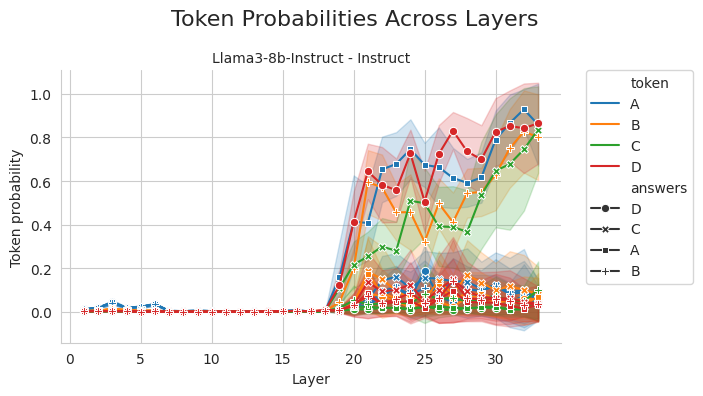

In [23]:
plot_token_probs(df_token_probs["mmlu"], ["A", "B", "C", "D"], 4)

# Statistics

In [24]:
stat_cols

['entropy', 'forward_kl', 'cross_entropy', 'max_prob', 'answer_token_entropy']

In [25]:
# Create a list of all stats to include
all_stats = ["entropy", "forward_kl", "max_prob", "answer_token_entropy"]

df_melted = df.melt(
    id_vars=['model', 'dataset', 'prompt', 'lens', 'subject', 'layer', 'correct', 'answers', 'gold', 'id'],
    value_vars=all_stats,
    var_name='statistic',
    value_name='value'
)

/tmp/ipykernel_81264/3742864975.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0.)


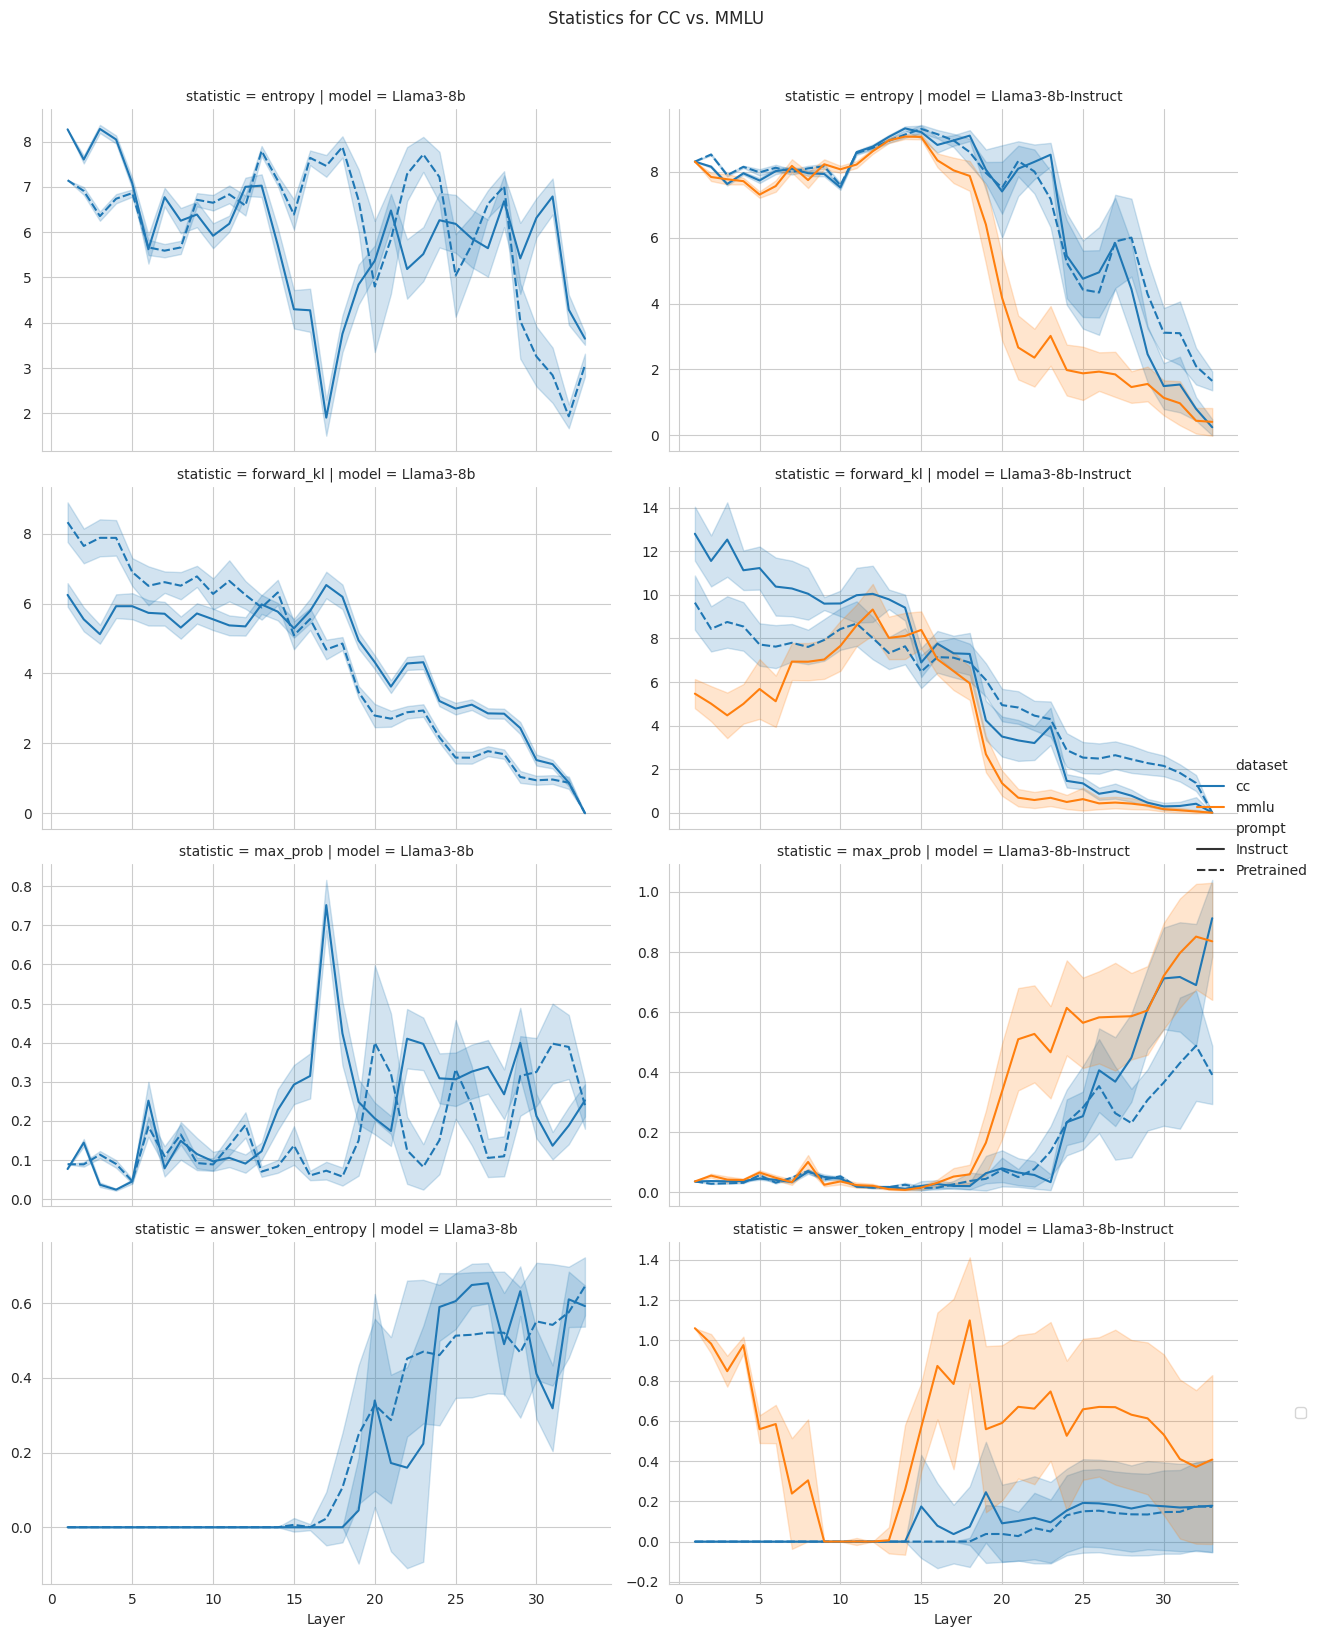

In [26]:
g = sns.relplot(data=df_melted, x="layer", y="value", row="statistic", col="model", hue="dataset", style="prompt", kind="line", errorbar='sd', height=4, aspect=1.5, facet_kws={'sharey': False, 'sharex': True})
g.fig.suptitle("Statistics for CC vs. MMLU", y=1.02)
g.set(xlabel="Layer", ylabel="")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()


In [27]:
g = sns.relplot(data=df_melted[df_melted["dataset"] == "cc"], x="layer", y="value", row="statistic", col="model", hue="correct", style="prompt", kind="line", errorbar='sd', height=4, aspect=1.5, facet_kws={'sharey': False, 'sharex': True})
g.fig.suptitle("Statistics for CC dataset", y=1.02)
g.set(xlabel="Layer", ylabel="")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

/tmp/ipykernel_556876/3818787591.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0.)


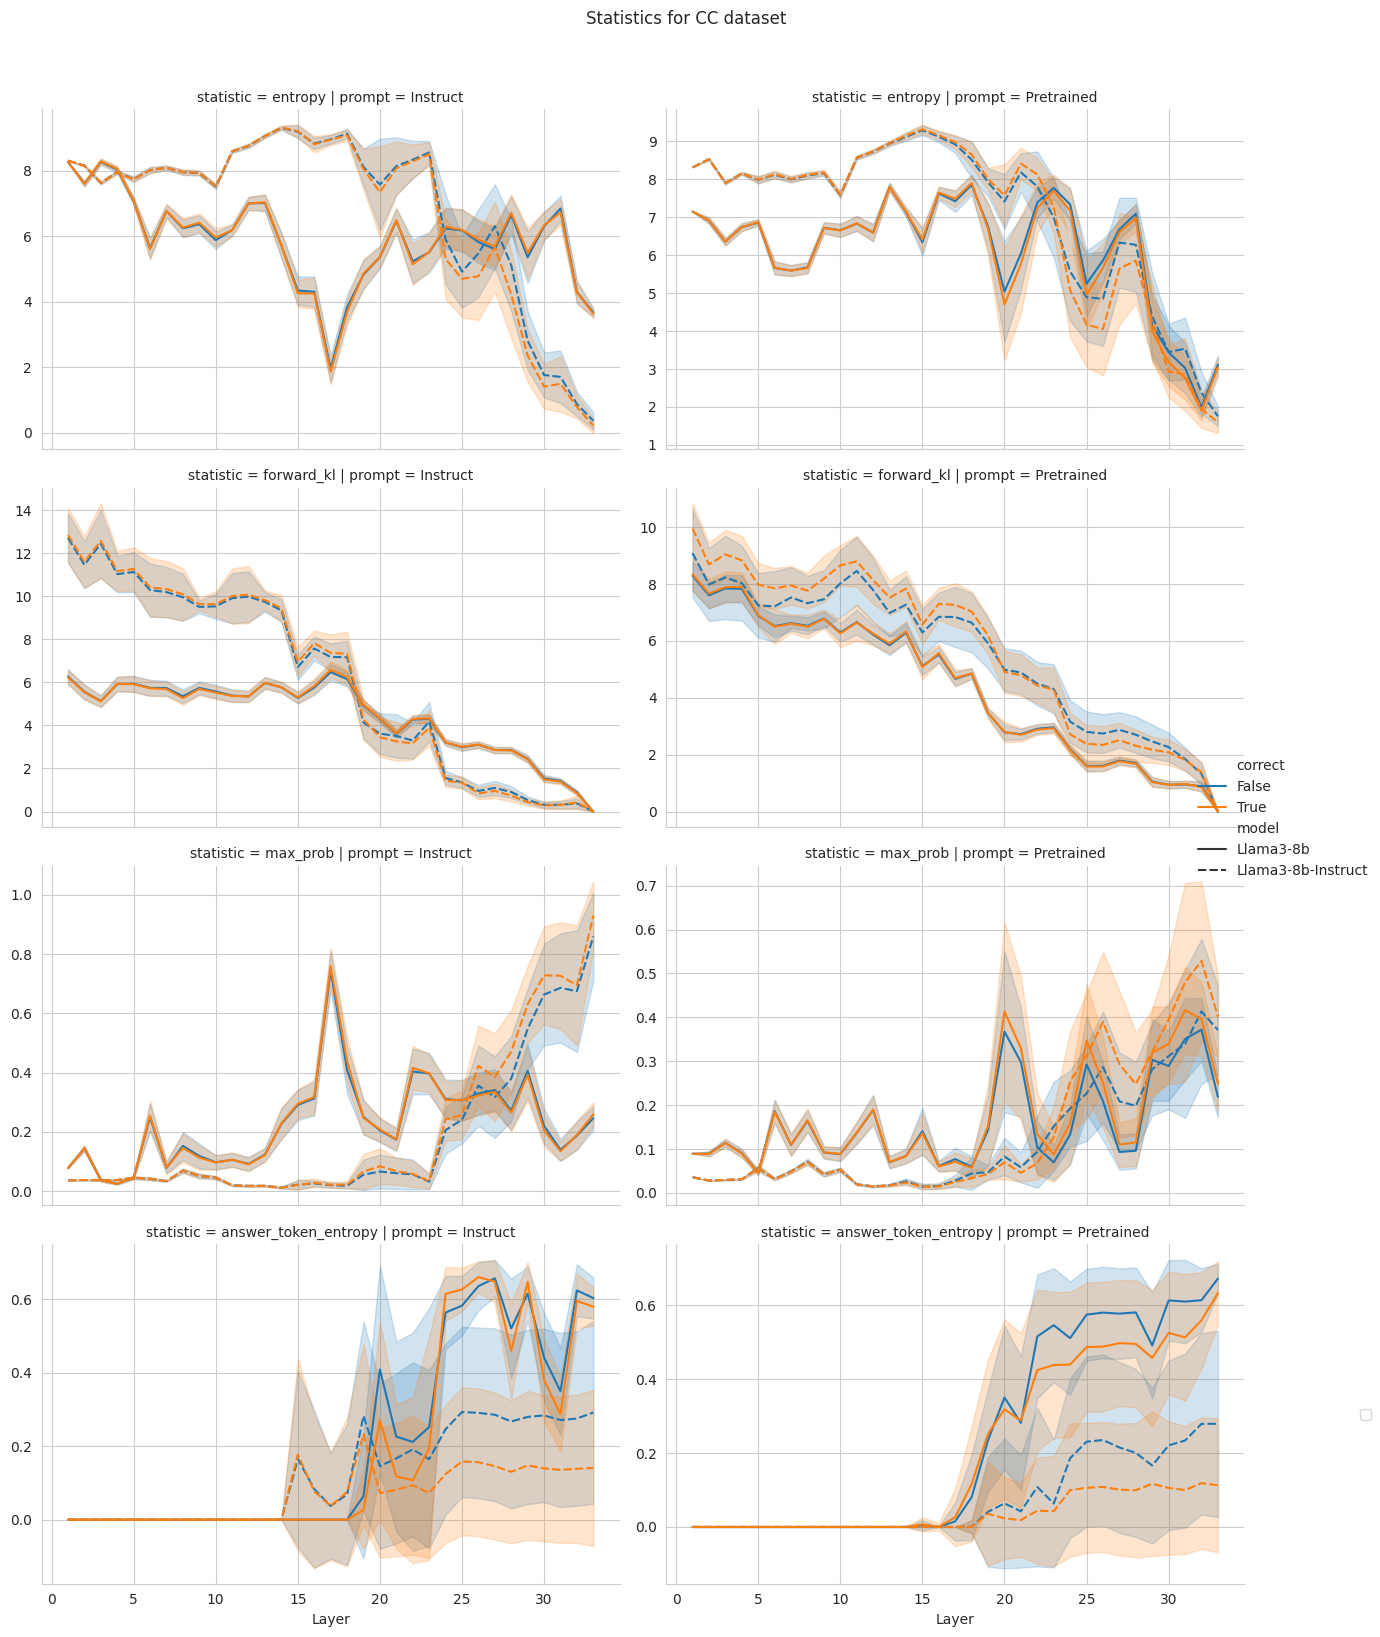

In [70]:
g = sns.relplot(data=df_melted[df_melted["dataset"] == "cc"], x="layer", y="value", row="statistic", col="prompt", hue="correct", style="model", kind="line", errorbar='sd', height=4, aspect=1.5, facet_kws={'sharey': False, 'sharex': True})
g.fig.suptitle("Statistics for CC dataset", y=1.02)
g.set(xlabel="Layer", ylabel="")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()


/tmp/ipykernel_556876/3439916679.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0.)


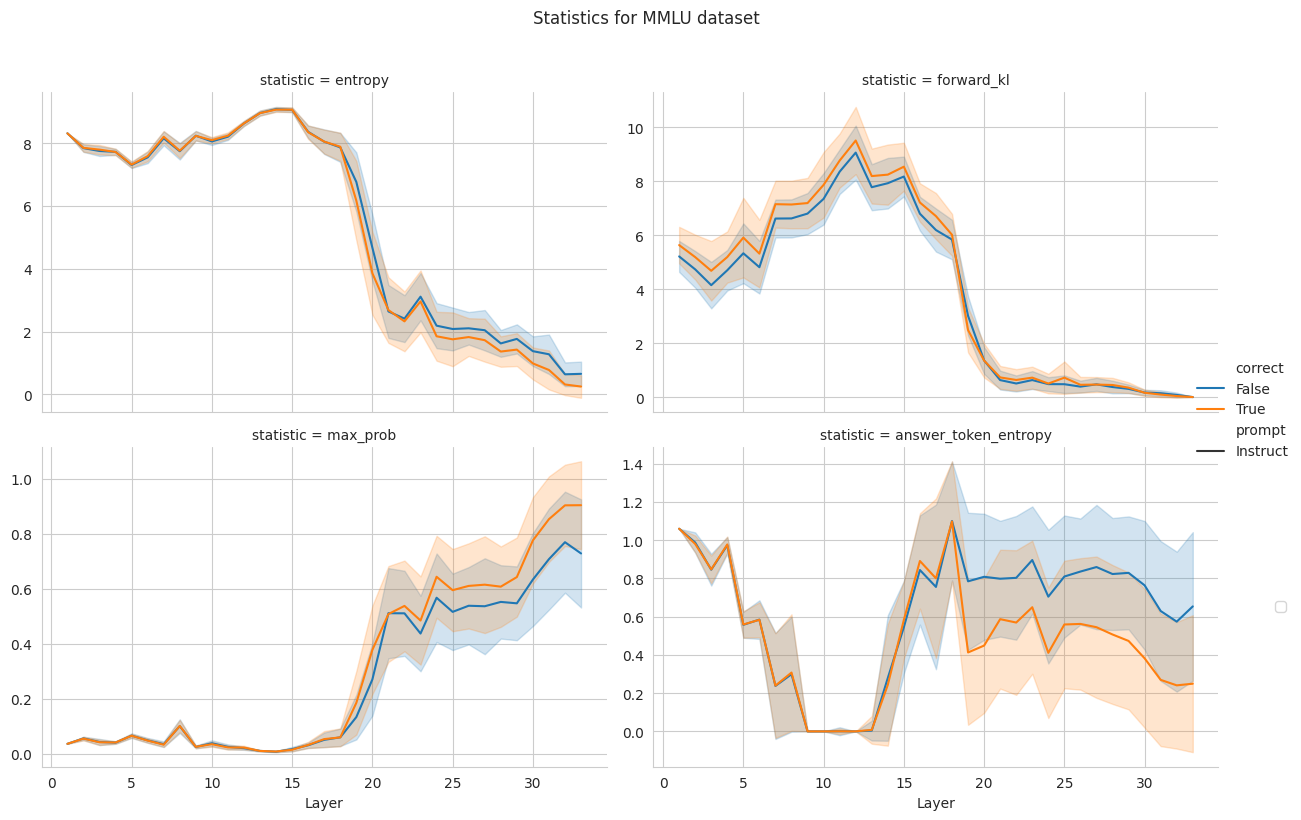

In [64]:
g = sns.relplot(data=df_melted[df_melted["dataset"] == "mmlu"], x="layer", y="value", col="statistic", col_wrap=2, hue="correct", style="prompt", kind="line", errorbar='sd', height=4, aspect=1.5, facet_kws={'sharey': False, 'sharex': True})
g.fig.suptitle("Statistics for MMLU dataset", y=1.02)
g.set(xlabel="Layer", ylabel="")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# MMLU statistics per subject

In [52]:
subject_groups = {
    "Science": [
        "college_physics",
        "anatomy",
        "conceptual_physics",
        "astronomy",
        "college_biology",
        "college_chemistry",
        "high_school_biology",
        "electrical_engineering",
        "computer_security",
    ],
    "Mathematics": [
        "high_school_statistics",
        "college_mathematics",
        "abstract_algebra",
        "high_school_mathematics",
    ],
    "Social Sciences": [
        "security_studies",
        "marketing",
        "prehistory",
        "human_sexuality",
        "public_relations",
        "sociology",
        "us_foreign_policy",
        "high_school_psychology",
        "high_school_microeconomics",
        "high_school_macroeconomics",
        "econometrics",
    ],
    "Law": [
        "professional_law",
        "jurisprudence",
        "international_law",
    ],
    "Business and Finance": [
        "global_facts",
        "management",
        "professional_accounting",
    ],
    "Humanities": [
        "philosophy",
        "world_religions",
        "high_school_government_and_politics",
        "formal_logic",
    ],
    "Medicine": [
        "clinical_knowledge",
        "nutrition",
    ],
    "Miscellaneous": [
        "miscellaneous",
    ]
}

df_melted["subject_group"] = df_melted["subject"].apply(lambda x: next((k for k, v in subject_groups.items() if x in v), "Miscellaneous"))

/tmp/ipykernel_556876/2862534595.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0.)


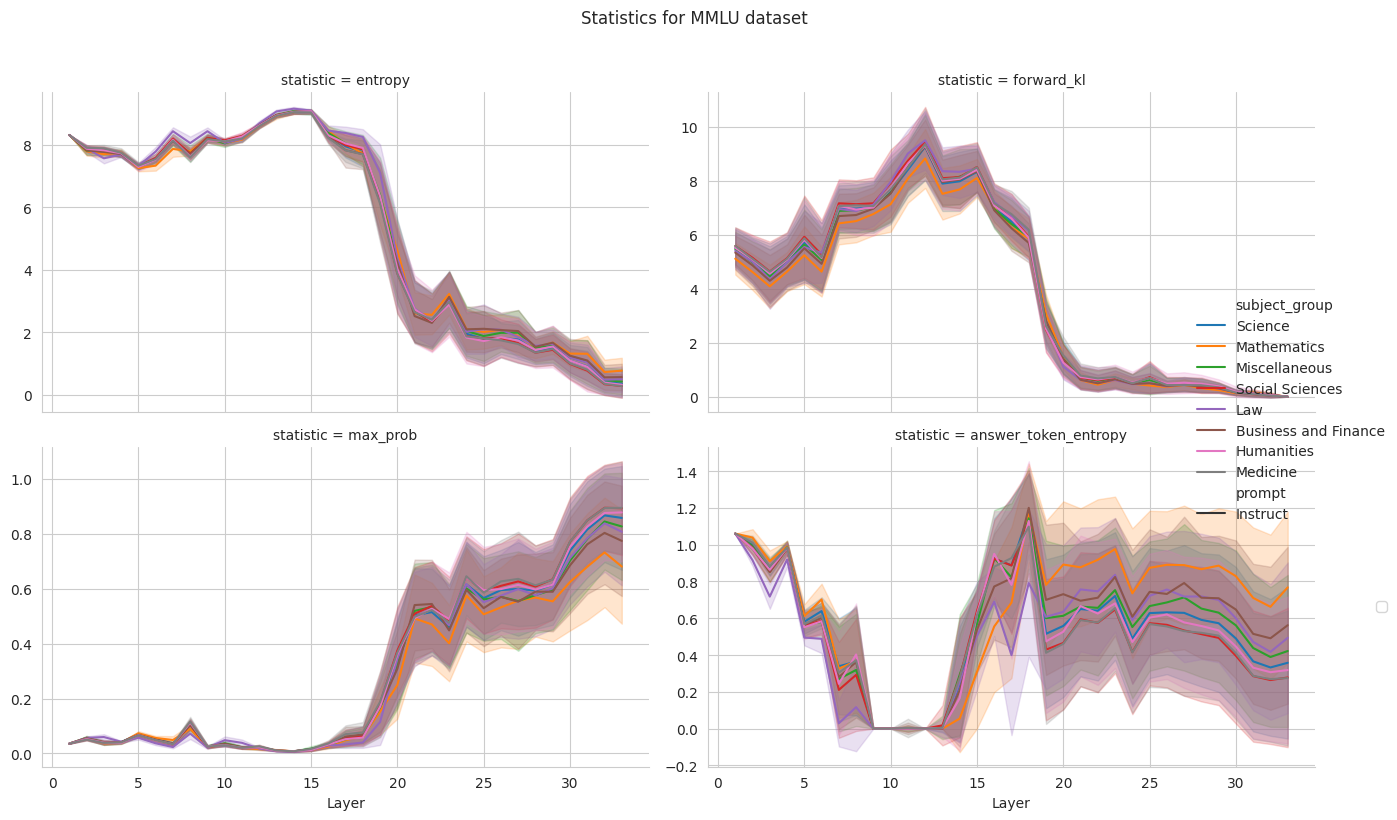

In [63]:
g = sns.relplot(data=df_melted[df_melted["dataset"] == "mmlu"], x="layer", y="value", col="statistic", col_wrap=2, hue="subject_group", style="prompt", kind="line", errorbar='sd', height=4, aspect=1.5, facet_kws={'sharey': False, 'sharex': True})
g.fig.suptitle("Statistics for MMLU dataset", y=1.02)
g.set(xlabel="Layer", ylabel="")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()
